# Assignment — Knowledge Graph Embedding

In this assignment we will see how to use the [TorchKGE](https://github.com/torchkge-team/torchkge) library for building knowledge graphs and its embeddings.

In [1]:
import numpy as np
import pandas as pd
pd.options.display.max_colwidth = 100
from zlib import adler32
import requests

### Task 1. Dataset exploration (1 points)

To begin with we are going to need a knowledge graph, so let us load a standard knowledge graph dataset called _Freebase-15k-237_.

In [2]:
df = pd.read_csv(
    "https://raw.githubusercontent.com/netspractice/network-science/main/datasets/freebase-237-merged-and-remapped.csv.gz", 
    names=['h', 'r', 't'])

In [3]:
df = df[~df.h.str.startswith('/') & ~df.t.str.startswith('/')]
df[::1000].head(10)

,h,r,t
0,"queens college, city university of new york",/education/educational_institution/students_graduates./education/education/student,carol leifer
1103,sharon stone,/award/award_nominee/award_nominations./award/award_nomination/award_nominee,jacob vargas
2210,japan,/location/country/capital,tokyo
3329,syphilis,/medicine/disease/risk_factors,male
4447,michael carlisle hall,/award/award_nominee/award_nominations./award/award_nomination/award_nominee,mena suvari
5555,alice in wonderland,/film/film/language,english language
6653,nauru,/location/country/official_language,english language
7743,ben harper,/people/person/spouse_s./people/marriage/type_of_union,marriage
8840,the perks of being a wallflower,/film/film/country,united states of america
9960,vice president,/business/job_title/people_with_this_title./business/employment_tenure/company,scripps howard broadcasting


There is h — head (also subject), r — relation (also predicat, label), t — tail (also object). The shape of the dataset is

In [4]:
df.shape

(282560, 3)

Let us check the number of unique entities and unique relations.

Write a funtion `n_ent_rel` that takes a dataset and returns a number of unique entities and unique relations.


In [5]:
def n_ent_rel(df):
    n_ent = len(set(df.h) | set(df.t))
    n_rel = df.r.unique()
    return n_ent, n_rel

In [6]:
n_ent, n_rel = n_ent_rel(df)
assert adler32(str(n_ent + n_ent).encode()) == 50266365
n_ent, n_rel

(13506,
 array(['/education/educational_institution/students_graduates./education/education/student',
        '/business/business_operation/industry',
        '/award/award_winning_work/awards_won./award/award_honor/award_winner',
        '/people/person/profession',
        '/film/film/other_crew./film/film_crew_gig/film_crew_role',
        '/tv/tv_program/tv_producer./tv/tv_producer_term/producer_type',
        '/location/location/contains',
        '/film/film/release_date_s./film/film_regional_release_date/film_release_region',
        '/film/film/release_date_s./film/film_regional_release_date/film_release_distribution_medium',
        '/music/genre/artists',
        '/people/person/spouse_s./people/marriage/type_of_union',
        '/education/educational_institution_campus/educational_institution',
        '/award/award_nominee/award_nominations./award/award_nomination/award',
        '/award/award_category/nominees./award/award_nomination/nominated_for',
        '/award/award_no

We can look at all facts about any entity via pandas API

In [7]:
df[df.h ==  'aleksandr pushkin'].head()

,h,r,t
4107,aleksandr pushkin,/people/person/profession,poet
14992,aleksandr pushkin,/influence/influence_node/influenced_by,johann wolfgang von goethe
19525,aleksandr pushkin,/people/person/nationality,russian empire
40237,aleksandr pushkin,/people/person/place_of_birth,moscow
47411,aleksandr pushkin,/influence/influence_node/influenced_by,william shakespeare


In [8]:
df[(df.h ==  'aleksandr pushkin') & (df.t == 'nikolai gogol')]

,h,r,t
145219,aleksandr pushkin,/influence/influence_node/peers./influence/peer_relationship/peers,nikolai gogol


In [9]:
df[(df.h ==  'nikolai gogol') & (df.t == 'aleksandr pushkin')]

,h,r,t
86362,nikolai gogol,/influence/influence_node/peers./influence/peer_relationship/peers,aleksandr pushkin
269512,nikolai gogol,/influence/influence_node/influenced_by,aleksandr pushkin


Let us try to find some facts in this dataset. For example, what is Harrison Ford's nationality? ("harrison ford" in the dataset)

Write a function `harrison_ford_nationality` that takes a dataset and returns the nationality.

_Hint: use `pandas.Series.str.contains` method_

In [10]:
def harrison_ford_nationality(df):
    tmp = df[df.h == 'harrison ford']
    return tmp[tmp.r.str.contains('nationality')].t.item()

In [11]:
assert adler32(harrison_ford_nationality(df).encode()) == 1948191013
harrison_ford_nationality(df)

'united states of america'

More tricky question: who are film directors of movies where Harrison Ford was?

Write a function `made_films_with_harrison_ford` that returns a set of directors' names.

In [12]:
def made_films_with_harrison_ford(df):
    tmp = df[df.h == 'harrison ford']
    films = set(tmp[tmp.r.str.contains('actor')].t)
    tmp = df[df.t.isin(films)]
    return list(set(tmp[tmp.r.str.contains('director')].h))

In [13]:
directors = made_films_with_harrison_ford(df)
assert adler32(str(sorted(directors)).encode()) == 3798415057
directors

['francis ford coppola',
 'ridley scott',
 'jon favreau filmography',
 'mike nichols',
 'george lucas',
 'robert zemeckis',
 'steven spielberg',
 'kathryn bigelow']

### Task 2. TransE embedding model (2 points)

TransE (translations in the embedding space) is a method which models relationships by interpreting them as translations operating on the low-dimensional embeddings of the entities.

Let us implement the model using TorchKGE — a Python module for knowledge graph embedding relying solely on Pytorch.

In [14]:
!pip install torchkge==0.16.25 -q

     |████████████████████████████████| 51kB 4.2MB/s 


In [15]:
import torch
from torch import nn
import torch.nn.functional as F
from torchkge import KnowledgeGraph
from torchkge.utils import Trainer
from torchkge.evaluation import LinkPredictionEvaluator
from torchkge.models.interfaces import TranslationModel
from torch.nn.init import xavier_uniform_

<img src='https://github.com/netspractice/ml-on-graphs/raw/main/assignment_knowledge_graph_embedding/kge.png' width=300>

The basic idea behind the model is that the functional relation induced by the $r$-labeled edges corresponds to a translation of the embeddings, i.e. we want that $h + r \approx t$ when ($h$, $r$, $t$) holds ($t$ should be a nearest neighbor of $h + r$), while $h + r$ should be far away from $t$ otherwise. Thereby, TransE scoring function is negative distance between $h+r$ and $t$

$$f(h, r, t) = -||h + r - t||$$

where $||\cdot||$ is L1 or L2 norm. The goal of the optimization procedure is learning optimal embeddings, such that the scoring function is able to assign high scores to positive statements and low scores to statements unlikely to be true. The most common loss function is Margin Loss that can be represented as

$$L = \text{ReLU}\left(\gamma - f(h, r, t) + f(h', r, t')\right)$$

where $\gamma > 0$ is a "margin" hyperparameter, the triplet $(h, r, t)$ is in a training set (positive) and the $(h', r, t')$ is in a set of *corrupted* (negative) triplets, that are composed of training triplets with either the head or tail replaced by a random entity (but not both at the same time).

We will use TorchKGE TranslationModel as a base for TransE class, here are some auxiliary methods: 

* `normalize_parameters` applies `L2` normalization for training stability
* `get_embeddings` returns the tensors representing entities and relations
* `lp_prep_cands` gets entities and relations embeddings for link prediction training process
* `forward` returns scores for positive triplets (`h`, `r`, `t`) and negative triplets (`nh`, `r`, `nt`)

In [16]:
class BaseTransE(TranslationModel):
    def __init__(self, num_entities, num_relations, dim=100):
        super(BaseTransE, self).__init__(num_entities, num_relations, dissimilarity_type='L2')
        self.num_entities = num_entities
        self.num_relations = num_relations
        self.dim = dim
        self.ent_embeddings = nn.Embedding(num_entities, self.dim)
        xavier_uniform_(self.ent_embeddings.weight.data)
        self.rel_embeddings = nn.Embedding(num_relations, self.dim)
        xavier_uniform_(self.rel_embeddings.weight.data)
        
        self.normalize_parameters()
        self.rel_embeddings.weight.data = F.normalize(self.rel_embeddings.weight.data, p=2, dim=1)

    def normalize_parameters(self):
        self.ent_embeddings.weight.data = F.normalize(self.ent_embeddings.weight.data, p=2, dim=1)

    def get_embeddings(self):
        self.normalize_parameters()
        return self.ent_embeddings.weight.data, self.rel_embeddings.weight.data
        
    def lp_prep_cands(self, h_idx, t_idx, r_idx):
        b_size = h_idx.shape[0]

        h_emb = self.ent_embeddings(h_idx)
        t_emb = self.ent_embeddings(t_idx)
        r_emb = self.rel_embeddings(r_idx)

        candidates = self.ent_embeddings.weight.data.view(1, self.num_entities, self.dim)
        candidates = candidates.expand(b_size, self.num_entities, self.dim)

        return h_emb, t_emb, candidates, r_emb
    
    def forward(self, h, t, nh, nt, r):
        return self.scoring_function(h, t, r), self.scoring_function(nh, nt, r)

Write a function `scoring_function` that takes a tensor `h`, `t`, `r` with triplets of the shape (number of triplets) and returns its L2 scores. For training stability, apply L2 normalization (`F.normalize`  with `p=2`) on entities embeddings before computing the scores. Note that `h`, `t`, `r` are tensors with integer IDs of entities and relations.

In [17]:
class TransE(BaseTransE):
    def scoring_function(self, h, t, r):
        h_emb = self.ent_embeddings(h)
        t_emb = self.ent_embeddings(t)
        r_emb = self.rel_embeddings(r)
        h_emb = F.normalize(h_emb, p=2, dim=1)
        t_emb = F.normalize(t_emb, p=2, dim=1)
        return - torch.norm(h_emb + r_emb - t_emb, p=2, dim=1)

In [18]:
torch.manual_seed(0)
model = TransE(num_entities=5, num_relations=2, dim=2)
model.ent_embeddings.weight.data = torch.randn(5, 2)
model.rel_embeddings.weight.data = torch.randn(2, 2)

h = torch.LongTensor([1, 1, 1])
r = torch.LongTensor([0, 1, 1])
t = torch.LongTensor([2, 2, 3])

with torch.no_grad():
    scores = model.scoring_function(h, t, r).numpy()
assert scores.shape == (3, ) # 3 triplets
assert adler32(str(scores.round(2)).encode()) == 628491186

Complete the class `MarginLoss` so that computes the losses among scores and returns an average loss. Positive and negative scores are tensors of the shape (number of triplets).

In [19]:
class MarginLoss(nn.Module):
    def __init__(self, margin):
        super().__init__()
        self.margin = margin
    def init(self, margin):
        super().init()
        self.margin = margin
    def forward(self, positive_scores, negative_scores):
        return F.relu(self.margin - positive_scores + negative_scores).mean()

In [20]:
loss_fn = MarginLoss(margin=0.5)
torch.manual_seed(0)
positive_scores = torch.randn(8)
negative_scores = torch.randn(8)
loss = loss_fn(positive_scores, negative_scores)
assert loss.shape == torch.Size([])
assert round(loss.item(), 2) == 0.79

Let us look at the WikiDataSet that presents country-specific subgraphs of Wikidata.

In [21]:
url = 'https://raw.githubusercontent.com/netspractice/network-science/main/datasets/countries_edges.tsv'
open('countries_edges.tsv', 'wb').write(requests.get(url).content)
url = 'https://raw.githubusercontent.com/netspractice/network-science/main/datasets/countries_entities.tsv'
open('countries_entities.tsv', 'wb').write(requests.get(url).content)
url = 'https://raw.githubusercontent.com/netspractice/network-science/main/datasets/countries_relations.tsv'
open('countries_relations.tsv', 'wb').write(requests.get(url).content);

In [22]:
edges = pd.read_csv('countries_edges.tsv', sep='	').values
entity_labels = pd.read_csv('countries_entities.tsv', sep='	', index_col=0).label.values
relation_labels = pd.read_csv('countries_relations.tsv', sep='	', index_col=0).label.values

In [23]:
edges_labeled = np.stack([entity_labels[edges[:, 0]], 
                          entity_labels[edges[:, 1]], 
                          relation_labels[edges[:, 2]]], axis=1)

df = pd.DataFrame(edges_labeled, columns=['h', 't', 'r'])[['h', 'r', 't']]
df.head()

,h,r,t
0,Belgium,country,Belgium
1,Belgium,diplomatic relation,Luxembourg
2,Belgium,diplomatic relation,Italy
3,Belgium,diplomatic relation,Germany
4,Belgium,diplomatic relation,Liechtenstein


Here are unique relations with the number of triplets

In [24]:
df.r.groupby(df.r).count()

r
applies to jurisdiction                                        1
basic form of government                                       3
biological process                                             1
capital                                                       34
capital of                                                    25
contains administrative territorial entity                    94
country                                                     1339
country of citizenship                                         5
country of origin                                              1
culture                                                        3
designated as terrorist by                                     9
different from                                               113
diplomatic relation                                         6145
enclave within                                                 3
facet of                                                      13
family                 

Convert our dataset into a TorchKGE knowledge graph

In [25]:
kg = KnowledgeGraph(
    pd.DataFrame(edges_labeled, columns=['from', 'to', 'rel']))

Split the dataset into train and test set. What differs from the standard method of randomly sampling N points to make up our test set, is that our data points are two entities linked by some relationship, and we need to take care to ensure that all entities are represented in train and test sets by at least one triple.



In [26]:
kg_train, kg_test = kg.split_kg()

Create required objects: model, loss, optimizer and trainer.

In [27]:
model = TransE(kg_train.n_ent, kg_train.n_rel, dim=64)
criterion = MarginLoss(margin=0.5)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

trainer = Trainer(
    model, criterion, kg_train, n_epochs=200, 
    batch_size=2048, optimizer=optimizer)

During training, positive triplets are selected, negative triplets are generated, margin loss is calculated and then the gradient step is performed.

In [28]:
trainer.run()

Let us evaluate our model on the link prediction task

In [29]:
evaluator = LinkPredictionEvaluator(model, kg_test)
evaluator.evaluate(b_size=128)

assert evaluator.hit_at_k(k=10)[0] > 0.3
assert evaluator.mean_rank()[0] < 70
assert evaluator.mrr()[0] > 0.1

In [30]:
print('Hit@10: {:.4f}'.format(evaluator.hit_at_k(k=10)[0]))
print('Mean Rank: {:.4f}'.format(evaluator.mean_rank()[0]))
print('MRR: {:.4f}'.format(evaluator.mrr()[0]))

Hit@10: 0.3729
Mean Rank: 65.1693
MRR: 0.1476


`Hit@k` indicates how many times in average a true triple was ranked in the top-k.

`Mean Rank` is a mean rank of the true entity when replacing alternatively head and tail in any fact of the dataset.

`MRR` is an average of mean recovery rank for head and tail replacement.

### Task 3. 2D entity embedding (2 points)

In [31]:
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

Similarly to node embedding visualization, we can plot 2D embeddings of entities of knowledge graph.

Write a function `ent_embeddgins` that takes the model, transforms entity embeddings into 2-dimenstional space via SVD, then finds 2 clusters via k-means and finally returns a tuple: np.array with embeddings and 0/1 labels of clusters.

In [32]:
def ent_embeddgins(model):
    ent_emb = model.get_embeddings()[0]    
    svd = TruncatedSVD()
    svd.fit(ent_emb)
    
    ent_emb = svd.transform(ent_emb)
    kmeans = KMeans(n_clusters = 2).fit(ent_emb)
    
    return (ent_emb, kmeans.labels_)

In [33]:
ent_emb, labels = ent_embeddgins(model)
assert ent_emb.shape == (1810, 2)
assert labels.shape == (1810,)
n_label1 = (labels == 1).sum()
n_label0 = (labels == 0).sum()
assert 0.14 < min(n_label1, n_label0) / max(n_label1, n_label0) < 0.16

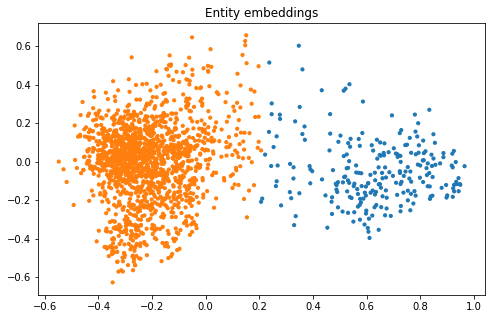

In [34]:
plt.figure(figsize=(8, 5))
colors = np.array(plt.cm.tab10.colors)
plt.scatter(ent_emb[:, 0], ent_emb[:, 1], s=10, c=colors[labels])
plt.title('Entity embeddings')
plt.show()

Let us look at some randomly chosen entities from each cluster. Here we use `kg.ent2ix` dictionary to get labels of entities.

In [35]:
ent_labels = np.array(list(kg.ent2ix.keys()))
print('First cluster: ', ', '.join(
    np.random.permutation(ent_labels[labels == 0])[:10]))
print()
print('Second cluster: ', ', '.join(
    np.random.permutation(ent_labels[labels == 1])[:10]))

First cluster:  Jamaica, Austria, Togo, Sahrawi Arab Democratic Republic, Ireland, Cook Islands, Papua New Guinea, Turkmenistan, Russian Soviet Federative Socialist Republic, Dominica

Second cluster:  Duchy of Pomerania, Himachal Pradesh, Third Republic of Madagascar, Taifa of Córdoba, Bukharan People's Soviet Republic, Duchy of Pannonian Croatia, Turdetania, Alamannia, Sri Ksetra Kingdom, Ethiopian Empire


### Task 4. Nearest neighbors of an entity (2 points)

In [36]:
from sklearn.neighbors import NearestNeighbors

Let us find a nearest neighbors of Belgium using embedding space.

Write a function `similar_countries` that takes a name of country, graph and model and returns a list with names of nearest countries. Use `model.get_embeddings()`.

In [41]:
def similar_countries(name, kg, model):

    ent_emb = model.get_embeddings()[0]    
    index = kg.ent2ix['Belgium']
    data = ent_emb[index]

    neighbors = NearestNeighbors()
    neighbors.fit(ent_emb)
    neigh_index = neighbors.kneighbors(data.reshape(1,-1))[1]
    
    

    similar  = [key for key, value in kg.ent2ix.items() if value in neigh_index]

    
    return similar 

In [42]:
similar = similar_countries('Belgium', kg, model)
assert 'Netherlands' in similar
similar

['Belgium', 'France', 'Hungary', 'Luxembourg', 'Netherlands']

### Task 5. Relation prediction  (1.5 points)

Let us consider these facts:
1. Belgium shares border with France
2. Belgium shares border with Switzerland
3. Belgium shares border with Nigeria

Only the fact 1 is truth, but it seems that the fact 2 is more likely than 3.

In [43]:
df[(df.h == 'Belgium') & (df.t == 'France')]

,h,r,t
8,Belgium,diplomatic relation,France
32,Belgium,shares border with,France


In [44]:
df[(df.h == 'Belgium') & (df.t == 'Switzerland')]

,h,r,t


In [45]:
df[(df.h == 'Belgium') & (df.t == 'Nigeria')]

,h,r,t


Now we can compare these facts using scoring function of TransE model to check our prior knowledge.

Write a function `belgium_facts` that takes a model, a graph and returns 3 values of scoring function for each fact. Use `model.scoring_function` with `torch.no_grad()`.

In [46]:
def belgium_facts(model, kg):

    index_Belgium = kg.ent2ix['Belgium']
    index_France = kg.ent2ix['France']
    index_Switzerland = kg.ent2ix['Switzerland']
    index_Nigeria = kg.ent2ix['Nigeria']
    index_rel = kg.rel2ix['shares border with']
    
    h = torch.LongTensor(3 * [index_Belgium])
    t = torch.LongTensor([index_France, index_Switzerland, index_Nigeria])
    r = torch.LongTensor(3 * [index_rel])
    with torch.no_grad():
      return model.scoring_function(h,t,r).numpy()

   

In [47]:
scores = belgium_facts(model, kg)
assert scores[0] > scores[1] > scores[2]
scores

array([-0.59725666, -0.69896793, -0.99426174], dtype=float32)

### Task 6. Tail prediction (1.5 points)

In [48]:
from sklearn.neighbors import NearestNeighbors

Recall that the main idea of TransE is to learn $h + r \approx t$, so let us find the closest tails for the head + relation pair.

Write a function `soviet_tail` that takes a model, graph and finds 5 nearest neighbors for the pair $h$ is "Soviet Union" and $r$ is "founded by".

In [49]:
def soviet_tail(model, kg):
    ent_emb, rel_emb = model.get_embeddings()
    index_ent = kg.ent2ix['Soviet Union']
    index_rel = kg.rel2ix['founded by']
    
    ent = ent_emb[index_ent].reshape(1, -1)
    rel = rel_emb[index_rel].reshape(1, -1)
    
    neighbors = NearestNeighbors()
    neighbors.fit(ent_emb)
    neigh_index = neighbors.kneighbors(ent + rel)[1]
   
    return [key for key, value in kg.ent2ix.items() if value in neigh_index ]

In [50]:
tails = soviet_tail(model, kg)
assert 'Russian Soviet Federative Socialist Republic' in tails
tails

['Empire of Japan',
 'Russian Empire',
 'Russian Soviet Federative Socialist Republic',
 'Second Polish Republic',
 'Soviet Union']